# Import

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
import pandas as pd
import pyplot_themes as themes
import sys 

# Turn off value-on-slice warning
pd.options.mode.chained_assignment = None  # default='warn'

# Make aesthetic
themes.theme_few(scheme='dark')
plt.rcParams.update({'font.family':'Arial'})

# Make dfs

In [298]:
N = 0 # Window around rumor/announcement to determine rumor_period/announcement_period 
DATE_FINDER = 3 # Window around rumor day to find 'actual' rumor day
OUTPUT_PATH = "../results/graphs/" # Where to save folders 

def make_max_value_dates(df, N):
    """
    Since it's not clear what the exact rumor day is, look at rumor days around GPT-generated rumor day and get 
    the one with max value
    """
    max_rumor_date = {}
    for uid in set(df['kwe'].tolist()):
        max_rumor_date[uid] = max_value_date_helper(df, uid, DATE_FINDER)
    return max_rumor_date

def max_value_date_helper(df, uid, N):
    df2 = df[df['kwe'] == uid]
    df2['abs_rumor_delta'] = np.abs(df2['rumor_delta'])
    filter_df = df2[df2['abs_rumor_delta'] <= N]
    max_date = filter_df.sort_values(['value', 'abs_rumor_delta'], ascending=False).head(1)['date'].tolist()[0]
    return max_date

def truncate_time(x, n):
    if abs(x) <= n:
        return 1 
    else:
        return 0


# Read in data
rumor_data = pd.read_json("../data/rum_data.json").T.reset_index()[['index', 'rumor_day', 'announce_day']]
df = pd.merge(left=pd.read_csv("../data/trend_data.csv"), right=rumor_data, left_on='event', right_on='index')
df = df[df['search_type'].isin(['web', "youtube"])]

# Make UID
df['kwe'] = df['kw'] + "_" + df['event']

# Get date difference between date and rumor, announcement day
df['rumor_delta'] = (pd.to_datetime(df['rumor_day']) - pd.to_datetime(df['date'])).dt.days.astype(int)
df['announce_delta'] = (pd.to_datetime(df['announce_day']) - pd.to_datetime(df['date'])).dt.days.astype(int)
max_value_rumor_dict = make_max_value_dates(df, 10)

# Also define a second rumor date 
df['rumor_day2'] = [max_value_rumor_dict[x] for x in df['kwe'].tolist()]
df['rumor2_delta'] = (pd.to_datetime(df['rumor_day2']) - pd.to_datetime(df['date'])).dt.days.astype(int)

# Various pivot tables
searchd = df.groupby(by=['event', 'date', 'search_type', 'rumor_day', 'rumor_day2', 'announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
kwd = df.groupby(by=['event', 'date', 'kw', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
eventd = df.groupby(by=['event', 'date', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
event_search = df.groupby(by=['event', 'date', 'search_type', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()

# Add features to DFs
for d in [df, kwd, eventd, searchd, event_search]:
    d['rumor_period'] = d['rumor_delta'].apply(lambda x: truncate_time(x, N))
    d['announce_period'] = d['announce_delta'].apply(lambda x: truncate_time(x, N))
    d['rumor2_period'] = d['rumor2_delta'].apply(lambda x: truncate_time(x, N))
    d['control_period'] = (d['rumor_period'] + d['announce_period']).apply(lambda x: 1 if x==0 else 0)
    d['control_period2'] = (d['rumor2_period'] + d['announce_period']).apply(lambda x: 1 if x==0 else 0)

    d['period'] = d.apply(lambda row: 'rumor_period' if row['rumor_period']==1 else ('announce_period' if row['announce_period']==1 else 'control'), axis=1)
    d['period2'] = d.apply(lambda row: 'rumor2_period' if row['rumor2_period']==1 else ('announce_period' if row['announce_period']==1 else 'control'), axis=1)

    d['year'] = pd.to_datetime(d['rumor_day']).dt.year
    if 'kw' in d.columns:
        d['val_prop'] = d['value']/d.groupby(['kw', 'event'])['value'].transform('sum')

# Descriptive Plots

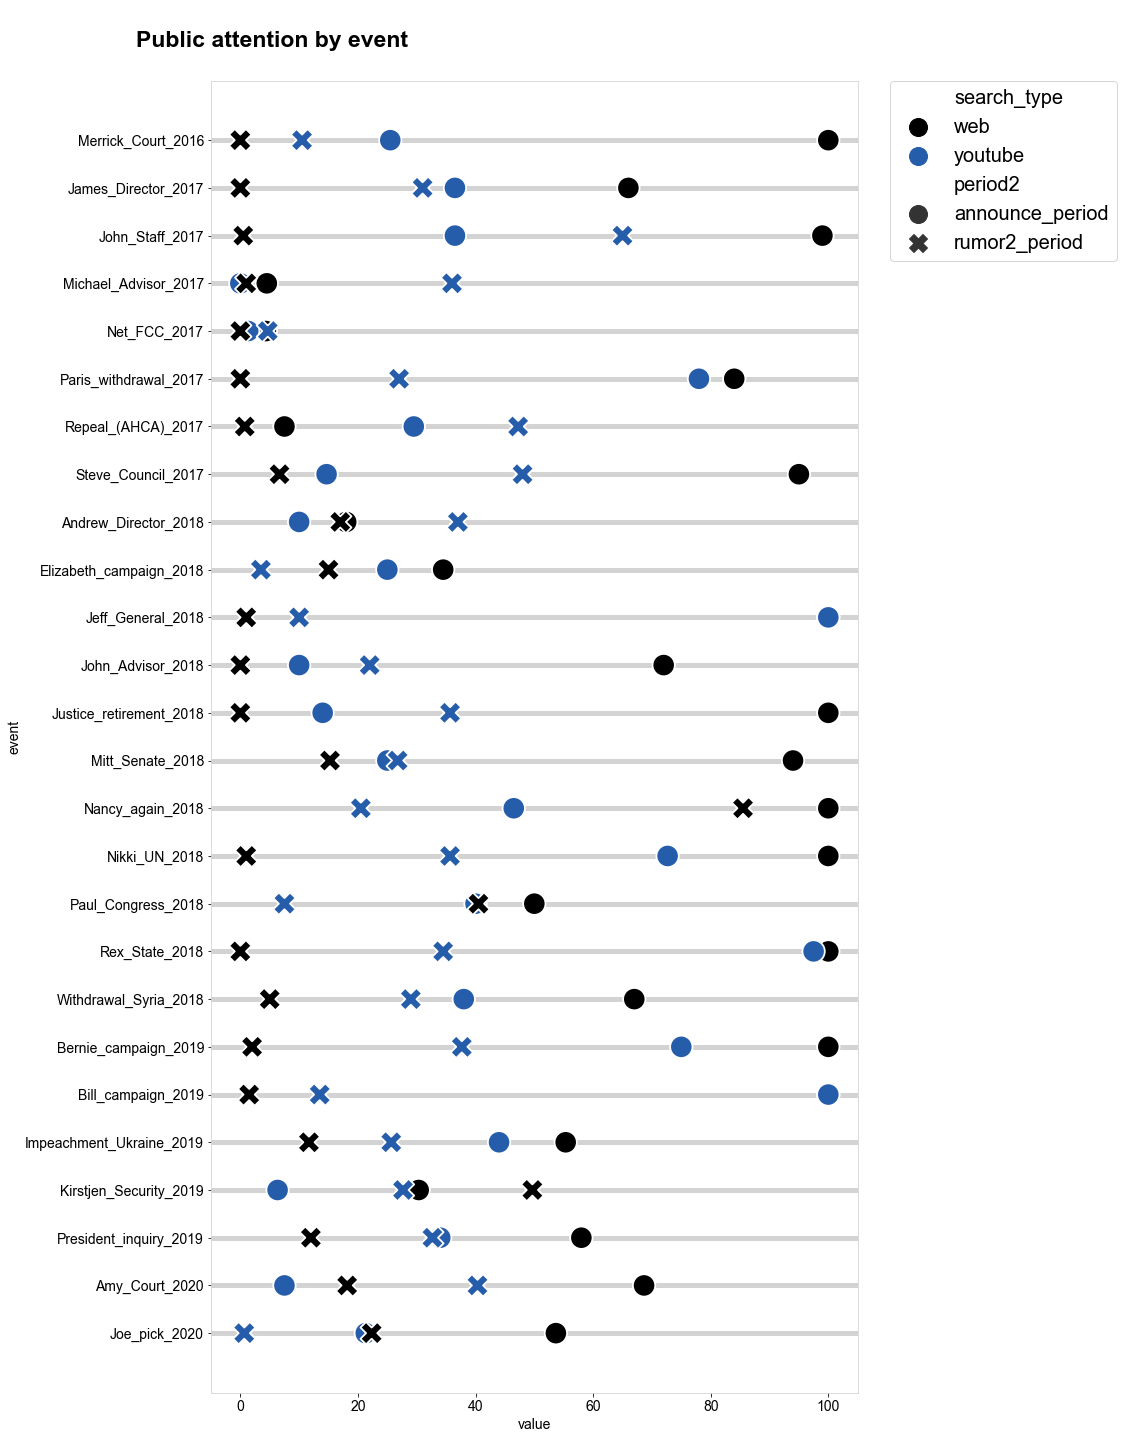

In [299]:
plt.figure(figsize=(16,20))
edf = event_search.groupby(by=['period2', 'event', 'search_type']).mean().reset_index()
sns.scatterplot(data=edf.query("control_period2==0").sort_values(by=['year', 'event']), y='event', s=500, x='value', style='period2', hue='search_type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=20, markerscale=3)
plt.suptitle(
    "\nPublic attention by event",
    fontsize=23,
    fontweight="bold",
    x=0.125,
    y=1,
    ha="left",
)
plt.tight_layout()
plt.grid(linewidth=5, axis='y')  #just add this
plt.savefig(f"{OUTPUT_PATH}all_events.png", dpi=300, bbox_inches='tight')

In [280]:
df[['rumor_day', "rumor_day2"]].sample(5)

,rumor_day,rumor_day2
10668,2018-03-22,2018-03-21
2562,2020-07-09,2020-07-06
9833,2017-03-01,2017-02-26
12649,2019-04-15,2019-04-15
11542,2020-09-19,2020-09-22


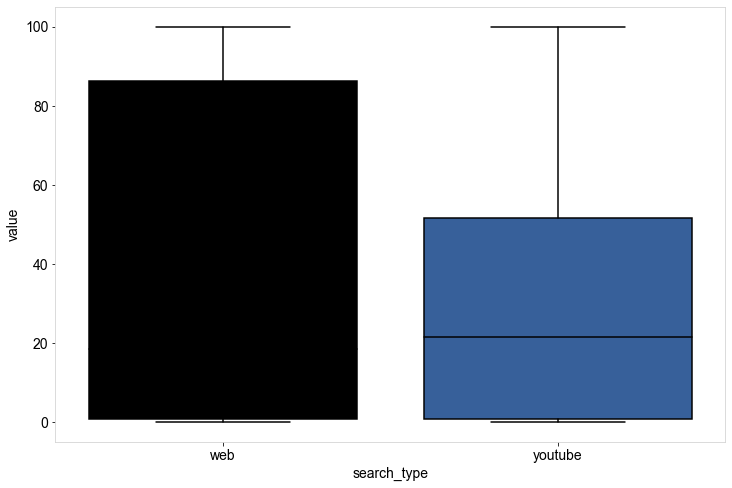

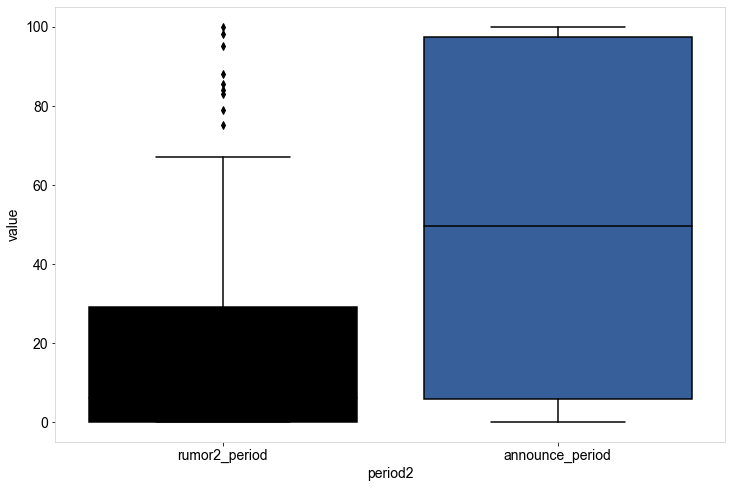

In [315]:
for break_out in ['search_type', 'period2']:

    sns.boxplot(data=event_search.query("control_period2==0"), x=break_out, y='value')
    plt.show()

In [301]:
edf = event_search.groupby(by=['period2', 'event', 'search_type']).mean().reset_index()
edf

,period2,event,search_type,rumor_delta,announce_delta,value,rumor2_delta,rumor_period,announce_period,rumor2_period,control_period,control_period2,year
0,announce_period,Amy_Court_2020,web,-7.000000,0.000000,68.666667,-6.333333,0.0,1.0,0.0,0.0,0.0,2020.0
1,announce_period,Amy_Court_2020,youtube,-7.000000,0.000000,7.500000,-6.333333,0.0,1.0,0.0,0.0,0.0,2020.0
2,announce_period,Andrew_Director_2018,web,-46.000000,0.000000,18.000000,-44.500000,0.0,1.0,0.0,0.0,0.0,2018.0
3,announce_period,Andrew_Director_2018,youtube,-46.000000,0.000000,10.000000,-44.500000,0.0,1.0,0.0,0.0,0.0,2018.0
4,announce_period,Bernie_campaign_2019,web,-30.000000,0.000000,100.000000,-28.666667,0.0,1.0,0.0,0.0,0.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,rumor2_period,Rex_State_2018,youtube,-1.500000,13.500000,34.500000,0.000000,0.5,0.0,1.0,0.5,0.0,2018.0
152,rumor2_period,Steve_Council_2017,web,0.666667,35.666667,6.666667,0.000000,0.0,0.0,1.0,1.0,0.0,2017.0
153,rumor2_period,Steve_Council_2017,youtube,0.666667,35.666667,48.000000,0.000000,0.0,0.0,1.0,1.0,0.0,2017.0
154,rumor2_period,Withdrawal_Syria_2018,web,1.000000,8.000000,5.000000,0.000000,0.0,0.0,1.0,1.0,0.0,2018.0


# Announcement Period X Search Type

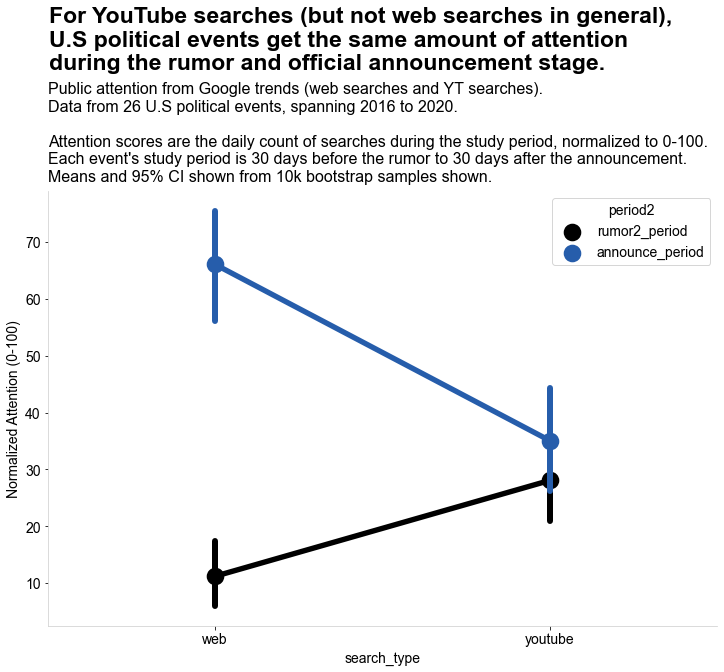

In [316]:
import matplotlib
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager

plt.rcParams.update({'font.family':'Arial'})

plt.figure(figsize=(12,8))

sns.pointplot(data=event_search.query("control_period2==0"), 
              errwidth=6, 
              errorbar='ci', 
              scale=2, 
              seed=416,
              n_boot=10000,
              hue='period2', 
              x='search_type', 
              y='value')


plt.ylabel("Normalized Attention (0-100)")

plt.title(
    (f"""\nPublic attention from Google trends (web searches and YT searches).\nData from {event_search['event'].nunique()} U.S political events, spanning {np.min(event_search['year'])} to {np.max(event_search['year'])}.\n\nAttention scores are the daily count of searches during the study period, normalized to 0-100.\nEach event's study period is 30 days before the rumor to 30 days after the announcement.\nMeans and 95% CI shown from 10k bootstrap samples shown."""),
    fontsize=16,
    pad=10,
    loc="left",
)

plt.suptitle(
    "For YouTube searches (but not web searches in general), \nU.S political events get the same amount of attention\nduring the rumor and official announcement stage.",
    fontsize=23,
    fontweight="bold",
    x=0.126,
    y=1.2,
    ha="left",
)

sns.despine()
plt.savefig(f"{OUTPUT_PATH}attn_interaction.png", dpi=300, bbox_inches='tight')


# Mixed Model (use R for any real analysis)

In [240]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [241]:
df['kwe'] = df['kw'] + df['event']
tdf = df.query("control_period!=999")
md = smf.mixedlm("value ~  C(year) + period2*search_type", tdf, groups=tdf['kwe']).fit()
ols = smf.ols("value ~  C(year) + period2*search_type + C(event)", tdf).fit()

## Mixed model, random intercepts for event#KW

In [242]:
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
==============================================================================================
Model:                         MixedLM             Dependent Variable:             value      
No. Observations:              10876               Method:                         REML       
No. Groups:                    64                  Scale:                          264.4240   
Min. group size:               136                 Log-Likelihood:                 -45864.5642
Max. group size:               234                 Converged:                      Yes        
Mean group size:               169.9                                                          
----------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------------------------------
Intercept                                        62.632    6.339   9.880 0.000  50.208  75.057
C(year)[T.2017]                                   1.775    6.371   0.279 0.781 -10.712  14.261
C(year)[T.2018]                                   3.006    6.242   0.482 0.630  -9.227  15.240
C(year)[T.2019]                                   9.446    6.421   1.471 0.141  -3.139  22.031
C(year)[T.2020]                                   3.389    6.812   0.498 0.619  -9.961  16.740
period2[T.control]                              -59.265    2.045 -28.980 0.000 -63.273 -55.257
period2[T.rumor2_period]                        -54.469    2.875 -18.948 0.000 -60.103 -48.835
search_type[T.youtube]                          -31.406    2.875 -10.925 0.000 -37.040 -25.772
period2[T.control]:search_type[T.youtube]        34.182    2.892  11.820 0.000  28.514  39.850
period2[T.rumor2_period]:search_type[T.youtube]  47.297    4.065  11.634 0.000  39.329  55.265
Group Var                                        70.541    0.821                              
==============================================================================================

"""

## OLS, event fe

In [243]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     66.09
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:53:47   Log-Likelihood:                -46480.
No. Observations:               10876   AIC:                         9.302e+04
Df Residuals:                   10845   BIC:                         9.325e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                       -1.265e+12   7.28e+12     -0.174      0.862   -1.55e+13     1.3e+13
C(year)[T.2017]                                 -4.835e+12   3.05e+13     -0.159      0.874   -6.45e+13    5.49e+13
C(year)[T.2018]                                  -1.85e+12   6.42e+12     -0.288      0.773   -1.44e+13    1.07e+13
C(year)[T.2019]                                 -3.139e+12   1.18e+13     -0.267      0.789   -2.62e+13    1.99e+13
C(year)[T.2020]                                  1.265e+12   7.28e+12      0.174      0.862    -1.3e+13    1.55e+13
period2[T.control]                                -59.2543      2.187    -27.089      0.000     -63.542     -54.967
period2[T.rumor2_period]                          -54.4484      3.075    -17.704      0.000     -60.477     -48.420
search_type[T.youtube]                            -31.3888      3.075    -10.207      0.000     -37.417     -25.361
C(event)[T.Andrew_Director_2018]                 3.114e+12   1.12e+13      0.277      0.782   -1.89e+13    2.51e+13
C(event)[T.Bernie_campaign_2019]                 4.404e+12   1.85e+13      0.238      0.812   -3.19e+13    4.07e+13
C(event)[T.Bill_campaign_2019]                   4.404e+12   1.85e+13      0.238      0.812   -3.19e+13    4.07e+13
C(event)[T.Elizabeth_campaign_2018]              3.114e+12   1.12e+13      0.277      0.782   -1.89e+13    2.51e+13
C(event)[T.Impeachment_Ukraine_2019]             4.404e+12   1.85e+13      0.238      0.812   -3.19e+13    4.07e+13
C(event)[T.James_Director_2017]                    6.1e+12   2.85e+13      0.214      0.830   -4.97e+13    6.19e+13
C(event)[T.Jeff_General_2018]                    3.114e+12   1.12e+13      0.277      0.782   -1.89e+13    2.51e+13
C(event)[T.Joe_pick_2020]                          -4.8349      1.045     -4.625      0.000      -6.884      -2.786
C(event)[T.John_Advisor_2018]                    3.114e+12   1.12e+13      0.277      0.782   -1.89e+13    2.51e+13
C(event)[T.John_Staff_2017]                        6.1e+12   2.85e+13      0.214      0.830   -4.97e+13    6.19e+13
C(event)[T.Justice_retirement_2018]              3.114e+12   1.12e+13      0.277      0.782   -1.89e+13    2.51e+13
C(event)[T.Kirstjen_Security_2019]               4.404e+12   1.85e+13      0.238      0.812   -3.19e+13    4.07e+13
C(event)[T.Merrick_Court_2016]                   1.265e+12   7.28e+12      0.174      0.862    -1.3e+13    1.55e+13
C(event)[T.Michael_Advisor_2017]                   6.1e+12   2.85e+13      0.214      0.830   -4.97e+13    6.19e+13
C(event)[T.Mitt_Senate_2018]                     3.114e+12   1.12e+13      0.277      0.782   -1.89e+13    2.51e+13
C(event)[T.Nancy_again_2018]                     3.114e+12   1.12e+